In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files



uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


In [4]:
data = pd.read_excel(list(uploaded.keys())[0])
data.head()
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [14]:
# Remove rows with missing CustomerID and invalid Quantity/UnitPrice
data = data.dropna(subset=['CustomerID'])
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]
data = data.drop("Description", axis = 1)
# Add a TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

data.head()  # Check the cleaned data


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [15]:
# Set the snapshot date to the most recent transaction date in the dataset
snapshot_date = data['InvoiceDate'].max()

# Group by CustomerID to calculate RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (number of unique invoices)
    'TotalPrice': 'sum'  # Monetary (total spending)
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

rfm.head()  # Display the RFM table


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [17]:
from sklearn.preprocessing import StandardScaler

# Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to a DataFrame for easier use
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)
rfm_scaled.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.334574,-0.425097,8.358668
12347.0,-0.905340,0.354417,0.250966
12348.0,-0.175360,-0.035340,-0.028596
12349.0,-0.735345,-0.425097,-0.033012
12350.0,2.174578,-0.425097,-0.191347


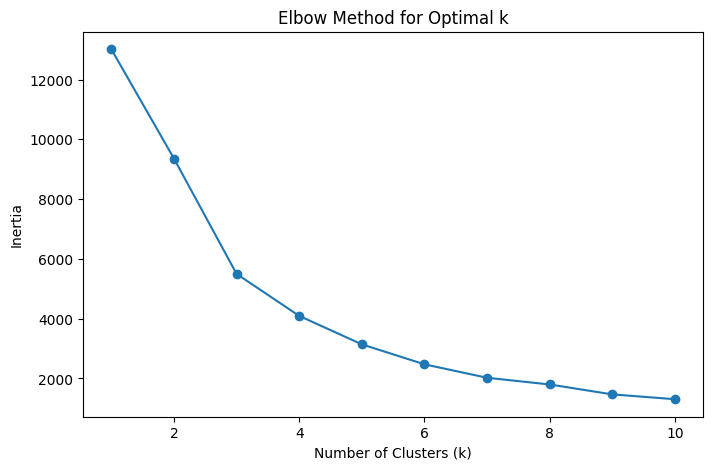

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [21]:
# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()  # View the RFM table with cluster assignments


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,3
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,1


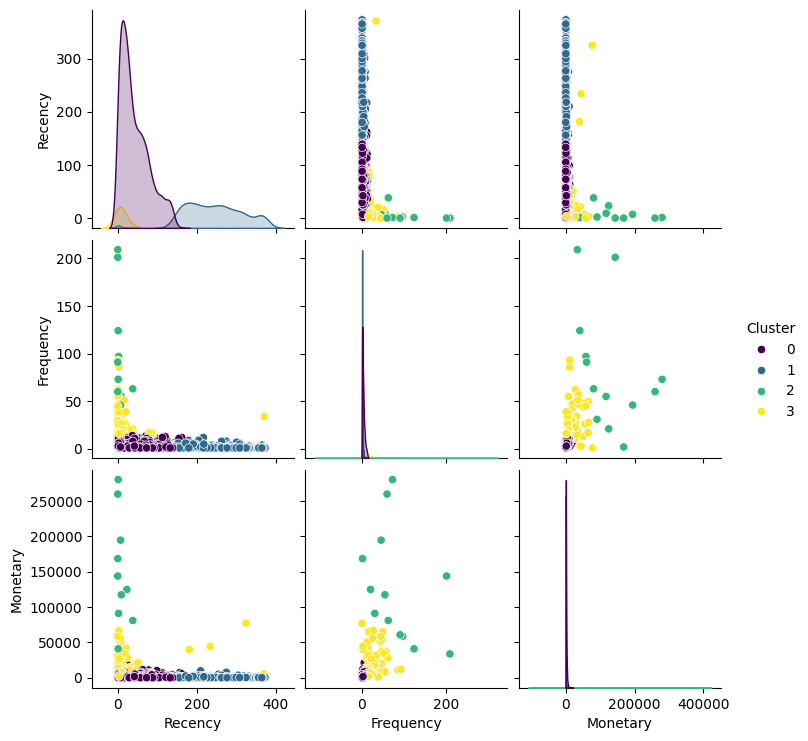

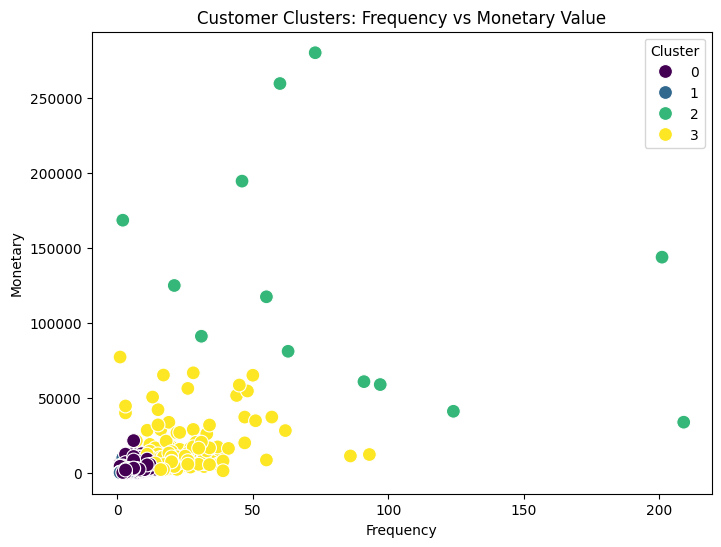

In [22]:
import seaborn as sns

# Pairplot for RFM features with clusters
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis')
plt.show()

# Scatterplot for Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Clusters: Frequency vs Monetary Value')
plt.show()


In [23]:
rfm.groupby('Cluster').mean()
from sklearn.metrics import silhouette_score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.616212846765192


Q1) Cluster 0 (Low Spend, Low Frequency): Customers who shop occasionally with minimal spending.

**Strategy: Use general promotions or discounts to encourage purchases.**

Cluster 1 (Moderate Spend, Low Frequency):
Occasional shoppers with slightly higher spending.

**Strategy: Offer targeted promotions or loyalty incentives to increase frequency.**

Cluster 2 (High Spend, Moderate Frequency):
High-value customers who purchase semi-regularly and spend significantly

**Strategy: Provide premium offers, personalized recommendations, and retention-focused campaigns.**

Cluster 3 (Moderate Spend, High Frequency):
Regular buyers with moderate spending per purchase.
**Strategy: Upsell products, bundle offers, or introduce subscription plans to maximize revenue.**

Q2) Additional Variables to improve clustering quality:
Purchase Timing (Seasonality): Include temporal features (e.g., month, weekday) to capture buying trends.
Geographical Region: Understand regional preferences to refine customer targeting.
Product Categories: Group products by category for better segmentation insights.
Discount Usage: Include data on discount utilization to identify price-sensitive customers

Q3) Hierarchical Clustering:
Useful for visualizing relationships but computationally expensive for large datasets.

DBSCAN:
Better for identifying noise or outliers (e.g., one-time buyers).

Gaussian Mixture Models (GMM):
Could capture overlapping clusters more effectively if the groups are not distinct.

However, K-Means performed reasonably well here, so alternative methods may yield marginal improvements.

Q4) Seasonality:
Evaluate how purchases vary across months or quarters to identify trends (e.g., holidays, sales events).
Cluster 3 (frequent buyers) might shop consistently, while Cluster 2 (high spenders) may peak during promotional periods.
Behavioral Trends:
Track how customers move between clusters (e.g., from low spenders to high spenders over time).


Q5) Use AWS cloud services for proper scaling and get access to insights and analysis.